In [53]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Cargar los datos de establecimientos con IDs
df_establecimientos = pd.read_csv('TablasModificadas/Datos_departamento/Datos_departamento_por_actividad_y_sexo_limpios.csv')

# Cargar el CSV con geometrías
df_geometrias = pd.read_csv('Departamentos (2010).csv')
df_geometrias.columns = ["Código","Nombre","Código_de_provincia","Nombre_de_provincia","Superficie_en_km2","Latitud_del_centroide","Longitud_del_centroide","Geometría_en_GeoJSON"]

# Convertir la columna GeoJSON a geometrías Shapely
df_geometrias['geometry'] = df_geometrias['Geometría_en_GeoJSON'].apply(
    lambda x: shape(json.loads(x)) if pd.notnull(x) and isinstance(x, str) else (
        shape(x) if pd.notnull(x) and isinstance(x, dict) else None
    )
)

# Convertir a GeoDataFrame
gdf_departamentos = gpd.GeoDataFrame(
    df_geometrias, 
    geometry='geometry',
    crs="EPSG:4326"
)

print("=== DATOS CARGADOS ===")
print(f"GeoDataFrame: {len(gdf_departamentos)} departamentos")
print(f"Datos establecimientos: {len(df_establecimientos)} registros")
print(f"Columnas establecimientos: {df_establecimientos.columns.tolist()}")

=== DATOS CARGADOS ===
GeoDataFrame: 525 departamentos
Datos establecimientos: 160481 registros
Columnas establecimientos: ['clae6', 'genero', 'id_departamentos', 'empresas_exportadoras', 'establecimientos', 'empleados']


In [54]:
# Agrupar establecimientos por código de departamento
establecimientos_por_id = df_establecimientos.groupby('id_departamentos').agg({
    'establecimientos': 'sum',
    'empleados': 'sum',
    'empresas_exportadoras': 'sum'
}).reset_index()

print(f"\nEstablecimientos agrupados por ID: {len(establecimientos_por_id)} departamentos")
print(establecimientos_por_id.head())



Establecimientos agrupados por ID: 527 departamentos
   id_departamentos  establecimientos  empleados  empresas_exportadoras
0              2007             54124     543181                   5873
1              2014             15519      88651                   1137
2              2021             14413      96510                    856
3              2028             10343     152463                   1408
4              2035              9027      66707                    628


In [55]:
# Unir por código de departamento (mucho más robusto)
gdf_merged = gdf_departamentos.merge(establecimientos_por_id, 
                                    left_on='Código', 
                                    right_on='id_departamentos', 
                                    how='left')

print(f"\n=== UNIÓN POR CÓDIGO ===")
print(f"Departamentos unidos: {len(gdf_merged)}")
print(f"Departamentos con datos de establecimientos: {gdf_merged['establecimientos'].notna().sum()}")
print(f"Departamentos sin datos: {gdf_merged['establecimientos'].isna().sum()}")

# Verificar algunos ejemplos de la unión
print("\nEjemplos de unión:")
muestra_union = gdf_merged[['Código', 'Nombre', 'Nombre_de_provincia', 'establecimientos']].head(10)
print(muestra_union)


=== UNIÓN POR CÓDIGO ===
Departamentos unidos: 525
Departamentos con datos de establecimientos: 512
Departamentos sin datos: 13

Ejemplos de unión:
   Código                  Nombre Nombre_de_provincia  establecimientos
0    6007           Adolfo Alsina        Buenos Aires             550.0
1    6014  Adolfo Gonzales Chaves        Buenos Aires             372.0
2    6021                 Alberti        Buenos Aires             301.0
3    6028         Almirante Brown        Buenos Aires            5403.0
4    6035              Avellaneda        Buenos Aires            7741.0
5    6042                Ayacucho        Buenos Aires             696.0
6    6049                    Azul        Buenos Aires            1970.0
7    6056            Bahía Blanca        Buenos Aires           10033.0
8    6063                Balcarce        Buenos Aires            1395.0
9    6070                Baradero        Buenos Aires             907.0


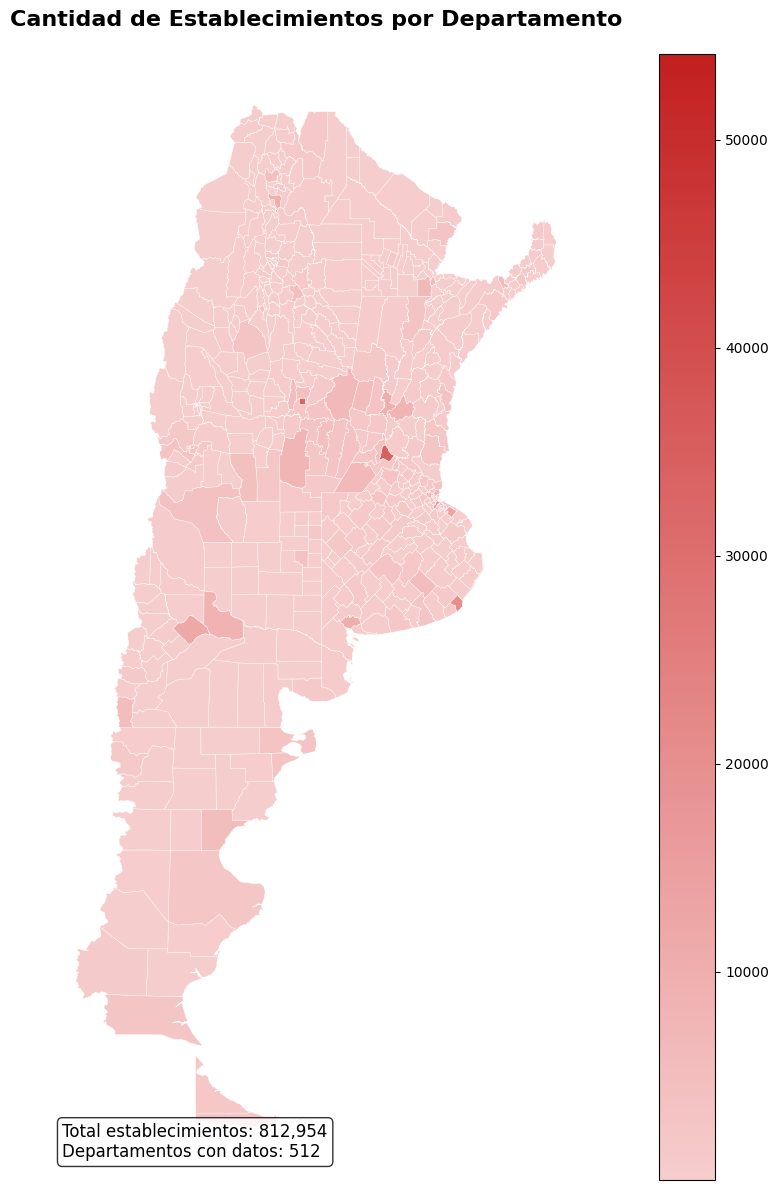

In [91]:
# Cartograma nacional usando la unión por código
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

cmap = LinearSegmentedColormap.from_list('establecimientos', ["#da2b2b3c", "#c31f1fff"])

gdf_merged.plot(column='establecimientos', 
                ax=ax, 
                cmap=cmap,
                legend=True,
                edgecolor="#FFFFFF",
                linewidth=0.3,
                missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'})

ax.set_title('Cantidad de Establecimientos por Departamento', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()

total_establecimientos = gdf_merged['establecimientos'].sum()
deptos_con_datos = gdf_merged['establecimientos'].notna().sum()

ax.text(0.02, 0.02, 
        f'Total establecimientos: {total_establecimientos:,.0f}\nDepartamentos con datos: {deptos_con_datos}', 
        transform=ax.transAxes, fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

In [92]:
# Filtrar Buenos Aires por código de provincia
# Primero veamos qué códigos de provincia tenemos
print("Códigos de provincia únicos:")
print(gdf_merged['Código_de_provincia'].unique())

# Filtrar Buenos Aires (código 06 para Buenos Aires - verificar según tus datos)
gdf_buenos_aires = gdf_merged[gdf_merged['Código_de_provincia'] == 6].copy()  # Ajustar el código si es necesario

print(f"\nDepartamentos de Buenos Aires: {len(gdf_buenos_aires)}")
print(f"Establecimientos en Buenos Aires: {gdf_buenos_aires['establecimientos'].sum():,.0f}")

Códigos de provincia únicos:
[ 6 46 50 70 10 14 18 22 26 30 34 38 42 54 58 62 66 74 78 82 86 90 94  2]

Departamentos de Buenos Aires: 134
Establecimientos en Buenos Aires: 302,682


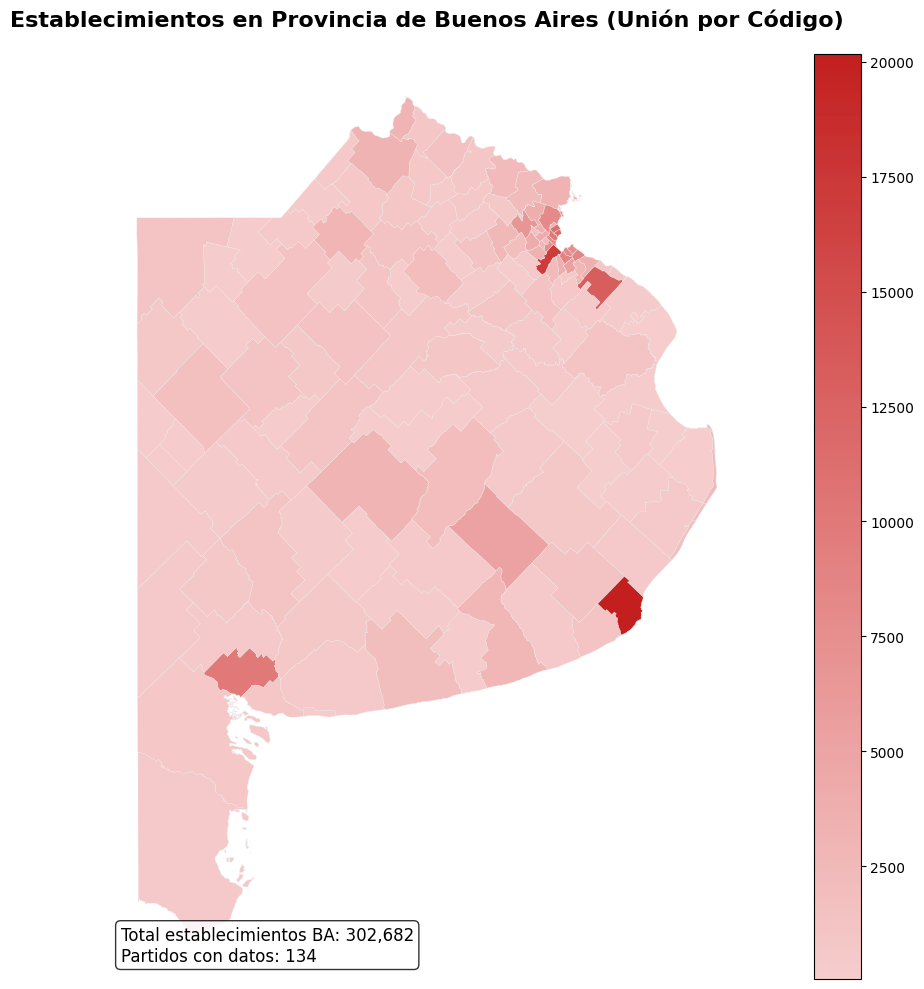

In [100]:
# Cartograma de Buenos Aires
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

gdf_buenos_aires.plot(column='establecimientos', 
                      ax=ax, 
                      cmap=cmap,
                      legend=True,
                      edgecolor="#EEEEEEFF",
                      linewidth=0.3,
                      missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'})

ax.set_title('Establecimientos en Provincia de Buenos Aires (Unión por Código)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()

total_ba = gdf_buenos_aires['establecimientos'].sum()
deptos_ba_con_datos = gdf_buenos_aires['establecimientos'].notna().sum()

ax.text(0.02, 0.02, 
        f'Total establecimientos BA: {total_ba:,.0f}\nPartidos con datos: {deptos_ba_con_datos}', 
        transform=ax.transAxes, fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

In [59]:
# Verificar la unión por código
print("=== DEBUGGING UNIÓN POR CÓDIGO ===")

# Códigos en establecimientos pero no en geometrías
codigos_estab = set(establecimientos_por_id['id_departamentos'].unique())
codigos_geo = set(gdf_departamentos['Código'].unique())

coinciden = codigos_estab.intersection(codigos_geo)
no_coinciden_estab = codigos_estab - codigos_geo
no_coinciden_geo = codigos_geo - codigos_estab

print(f"Códigos que coinciden: {len(coinciden)}")
print(f"Códigos en establecimientos pero no en geo: {len(no_coinciden_estab)}")
if no_coinciden_estab:
    print(f"  Ejemplos: {list(no_coinciden_estab)[:5]}")
print(f"Códigos en geo pero no en establecimientos: {len(no_coinciden_geo)}")
if no_coinciden_geo:
    print(f"  Ejemplos: {list(no_coinciden_geo)[:5]}")

# Muestra de códigos que sí coinciden
print(f"\nMuestra de códigos que coinciden:")
for codigo in list(coinciden)[:5]:
    nombre_geo = gdf_departamentos[gdf_departamentos['Código'] == codigo]['Nombre'].iloc[0]
    establecimientos = establecimientos_por_id[establecimientos_por_id['id_departamentos'] == codigo]['establecimientos'].iloc[0]
    print(f"  {codigo}: {nombre_geo} - {establecimientos:,.0f} establecimientos")

=== DEBUGGING UNIÓN POR CÓDIGO ===
Códigos que coinciden: 512
Códigos en establecimientos pero no en geo: 15
  Ejemplos: [np.int64(2049), np.int64(6466), np.int64(2084), np.int64(2021), np.int64(2056)]
Códigos en geo pero no en establecimientos: 13
  Ejemplos: [np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005)]

Muestra de códigos que coinciden:
  90112: Trancas - 162 establecimientos
  6147: Carlos Casares - 694 establecimientos
  86021: Atamisqui - 8 establecimientos
  90119: Yerba Buena - 1,852 establecimientos
  6154: Carlos Tejedor - 284 establecimientos


In [60]:
# Estadísticas finales
print(f"\n=== ESTADÍSTICAS FINALES (UNIÓN POR CÓDIGO) ===")
print(f"Total departamentos en GeoJSON: {len(gdf_departamentos)}")
print(f"Total departamentos en datos: {len(establecimientos_por_id)}")
print(f"Coincidencias exitosas: {len(coinciden)}")
print(f"Establecimientos totales mapeados: {gdf_merged['establecimientos'].sum():,.0f}")

# Eficiencia de la unión
eficiencia = (len(coinciden) / len(gdf_departamentos)) * 100
print(f"Eficiencia de unión: {eficiencia:.1f}%")


=== ESTADÍSTICAS FINALES (UNIÓN POR CÓDIGO) ===
Total departamentos en GeoJSON: 525
Total departamentos en datos: 527
Coincidencias exitosas: 512
Establecimientos totales mapeados: 812,954
Eficiencia de unión: 97.5%


Creando cartogramas difuminados...


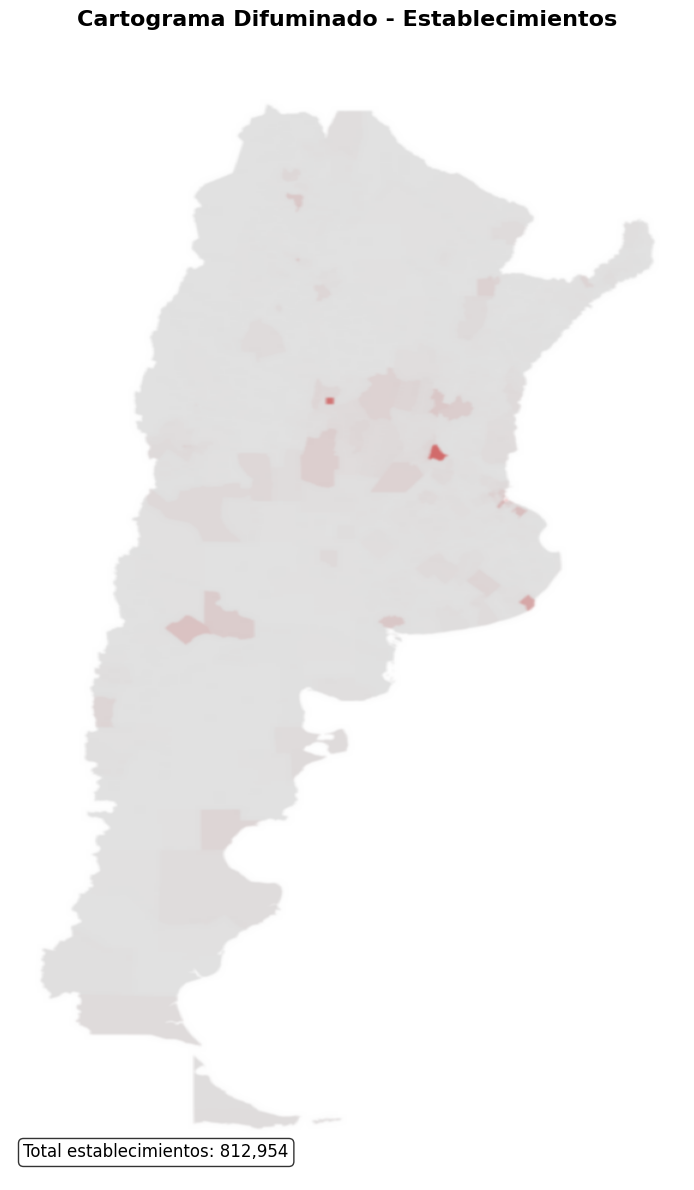

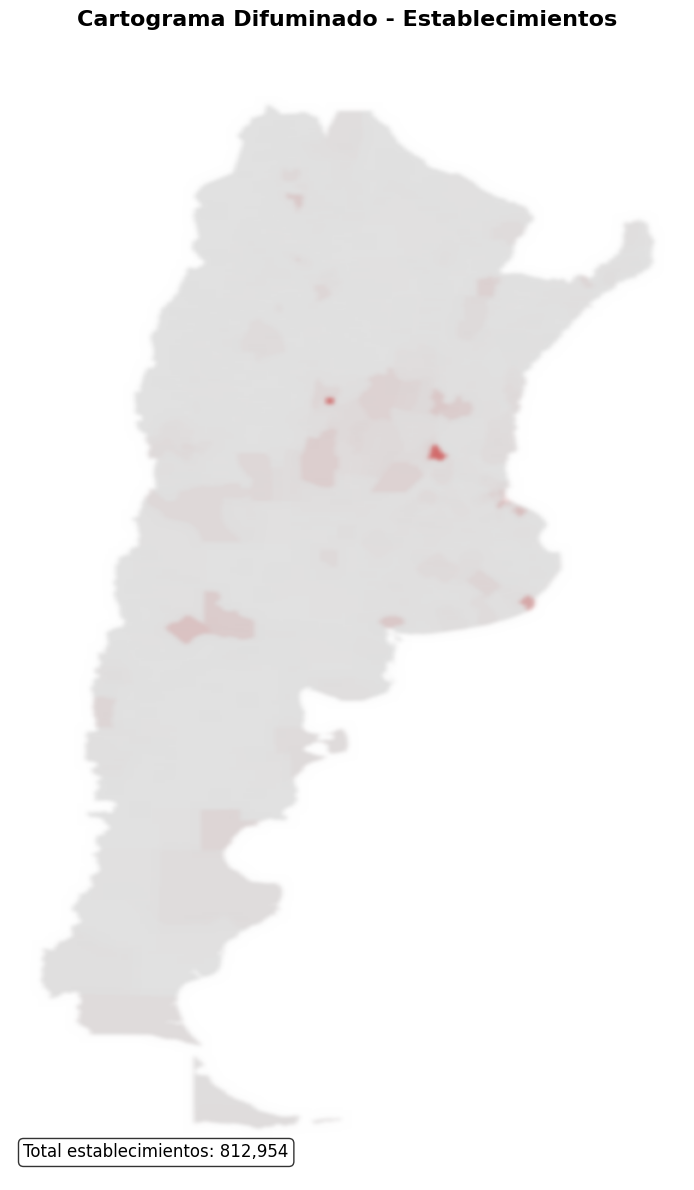

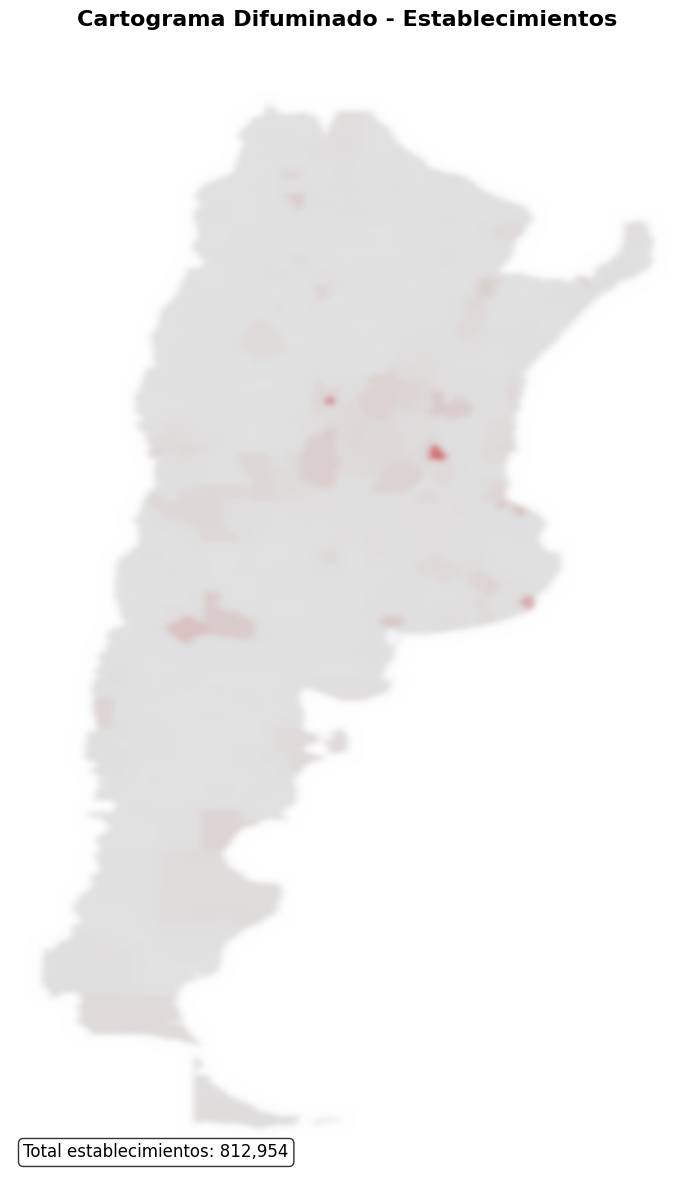

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import io
from PIL import Image

# Método 1: Usando buffer corregido
def crear_cartograma_difuminado(gdf, columna='establecimientos', sigma=2, figsize=(16, 12)):
    """Crea un cartograma difuminado usando Gaussian blur"""
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plot normal para obtener los bounds
    gdf.plot(column=columna, ax=ax, cmap=cmap, 
             edgecolor="#D4D4D4", linewidth=0.3)
    
    # Obtener límites
    xmin, xmax, ymin, ymax = ax.axis()
    ax.cla()
    
    # Crear figura temporal
    fig_temp = plt.figure(figsize=figsize, dpi=100)
    ax_temp = fig_temp.add_subplot(111)
    
    # Plot sin bordes para mejor blur
    gdf.plot(column=columna, ax=ax_temp, cmap=cmap, edgecolor="none")
    ax_temp.set_xlim(xmin, xmax)
    ax_temp.set_ylim(ymin, ymax)
    ax_temp.axis('off')
    ax_temp.set_position([0, 0, 1, 1])  # Usar todo el espacio
    
    # Guardar en buffer y convertir a array
    buf = io.BytesIO()
    fig_temp.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, dpi=100)
    buf.seek(0)
    img = Image.open(buf)
    image_array = np.array(img)
    
    # Aplicar Gaussian blur
    blurred_array = ndimage.gaussian_filter(image_array, sigma=[sigma, sigma, 0])
    
    plt.close(fig_temp)
    
    # Plotear la versión difuminada
    ax.imshow(blurred_array, extent=[xmin, xmax, ymin, ymax])
    ax.set_title(f'Cartograma Difuminado - {columna.title()}', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_axis_off()
    
    # Agregar información
    total = gdf[columna].sum()
    ax.text(0.02, 0.02, 
            f'Total {columna}: {total:,.0f}', 
            transform=ax.transAxes, fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    return fig, ax

# Probar con diferentes niveles de difuminado
print("Creando cartogramas difuminados...")

# Sigma bajo (poco difuminado)
fig1, ax1 = crear_cartograma_difuminado(gdf_merged, sigma=1)
plt.show()

# Sigma medio
fig2, ax2 = crear_cartograma_difuminado(gdf_merged, sigma=2)
plt.show()

# Sigma alto (muy difuminado)
fig3, ax3 = crear_cartograma_difuminado(gdf_merged, sigma=3)
plt.show()